# 01-Exploration

Goal of this notebook is to just explore the dataset, set up some basic utilities 

In [1]:
# %%bash

# pip install attrdict
# pip install timm

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
import os
import tqdm

import seaborn as sns
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.utils import make_grid
from attrdict import AttrDict
import torch
import yaml
from sklearn.model_selection import StratifiedKFold
import copy
# from tqdm import tqdm_notebook


In [2]:
# check the package version to get reproducible env 
# source: https://www.kaggle.com/rtatman/get-the-versions-of-imported-packages

"""
To be used for kaggle notebook
"""

import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system names
        if name == "PIL":
            name = "Pillow"
        elif name == "sklearn":
            name = "scikit-learn"

        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

tqdm==4.62.1
torchvision==0.8.2+cu110
torch==1.7.1+cu110
seaborn==0.11.2
scikit-learn==0.23.2
pandas==1.2.5
numpy==1.19.5
matplotlib==3.4.3
attrdict==2.0.1


In [3]:



"""
To add to utility.py
"""

def seed_everything(seed=1234):
    """
    Utility function to seed everything
    source: https://www.kaggle.com/bminixhofer/deterministic-neural-networks-using-pytorch
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

    

def read_yaml(filename):
    """
    Read yaml configuation and returns the dict

    Parameters
    ----------
    filename: string
        Path including yaml file name
    """

    with open(filename) as f:
        config = yaml.safe_load(f)

    return config


    
# configs

# config is different in kaggle


class BaseConfigLoader:
    
    def __init__(self,config_path):
        # TODO: if None, should load yaml
        self.config = read_yaml(config_path)
            
    def load_config(self):
        return AttrDict(self.config)

In [4]:
# load config

#base_config_manager = BaseConfigLoader("../input/d/germmie/config/config.yaml")
base_config_manager = BaseConfigLoader("../config/config.yaml")

In [5]:
# define device

device = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [6]:
print(device)

cuda


# Loading Data

We will load the data by creating torch datasets as well as dataloader

In [8]:
seed_everything()

In [7]:
# this is specific to kaggle
# if running in GCS, replace with our GCP bucket 
# get cache location of the dataset 
# GCS_DS_PATH = KaggleDatasets().get_gcs_path()
# file_path = base_config_manager.load_config().filepath.kaggle #"/kaggle/input/petfinder-pawpularity-score/"
file_path = base_config_manager.load_config().filepath.gcs #"/kaggle/input/petfinder-pawpularity-score/"

train_df = pd.read_csv(os.path.join(file_path,"train.csv"))
test_df = pd.read_csv(os.path.join(file_path,"test.csv"))


In [8]:
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [9]:
test_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [10]:
class pawnetDataset(torch.utils.data.Dataset):
    """
    Dataset
    Based on template https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    """
    def __init__(self,annotation_df, img_dir,transform=None,target_transform=None,test=False,custom_len=None):
        self.annotation_df = annotation_df
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.test=test # if dataset contains labels
        self.custom_len=custom_len # if we want to define our own epoch
        
        
    def __len__(self):
        """Define 1 epoch"""
        if self.custom_len is None:
            return len(self.annotation_df)
        else:
            return self.custom_len
    
    def __getitem__(self,idx):
        """called batch num of times"""
        img_path = os.path.join(self.img_dir, self.annotation_df.iloc[idx, 0]) # ID is column index 0
        image = read_image(img_path+".jpg")
        if self.test:
            label = 0
        else:
            label = self.annotation_df.iloc[idx, 13] # Pawpularity is column index 13
            
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [11]:
# create loaders - just for visualization
# for visualization, we need them to be in the same size
#file_path = "/kaggle/input/petfinder-pawpularity-score/"

train_data = pawnetDataset(annotation_df=train_df,img_dir = os.path.join(file_path,"train"),transform = T.Compose([T.Resize([224,224])]))
test_data = pawnetDataset(annotation_df=test_df,img_dir = os.path.join(file_path,"test"),transform = T.Compose([T.Resize([224,224])]),test=True)
train_loaders = torch.utils.data.DataLoader(train_data,batch_size=1,shuffle=False)
test_loaders = torch.utils.data.DataLoader(test_data,batch_size=39,shuffle=False)

In [14]:
# helper to visualize
# https://towardsdatascience.com/beginners-guide-to-loading-image-data-with-pytorch-289c60b7afec

def visualize_images(images,nmax):
    """
    visual images in our loaders
    
    Parameters
    ---------
    images: image tensor of size (N,H,W,C)
    nmax: max number of images to plot
    """
    fig,axes = plt.subplots(figsize=(16,16))
    axes.set_xticks([])
    axes.set_yticks([])
    axes.imshow( make_grid((images.detach()[:nmax]),nrow=6).permute(1,2,0)) # H,W,C
    plt.savefig("train_batch_images.png")
    
def visualize_batch_images(data_loaders,nmax=64):
    images, labels = iter(data_loaders).next() # get batch size of image tensor
    visualize_images(images,nmax=nmax)

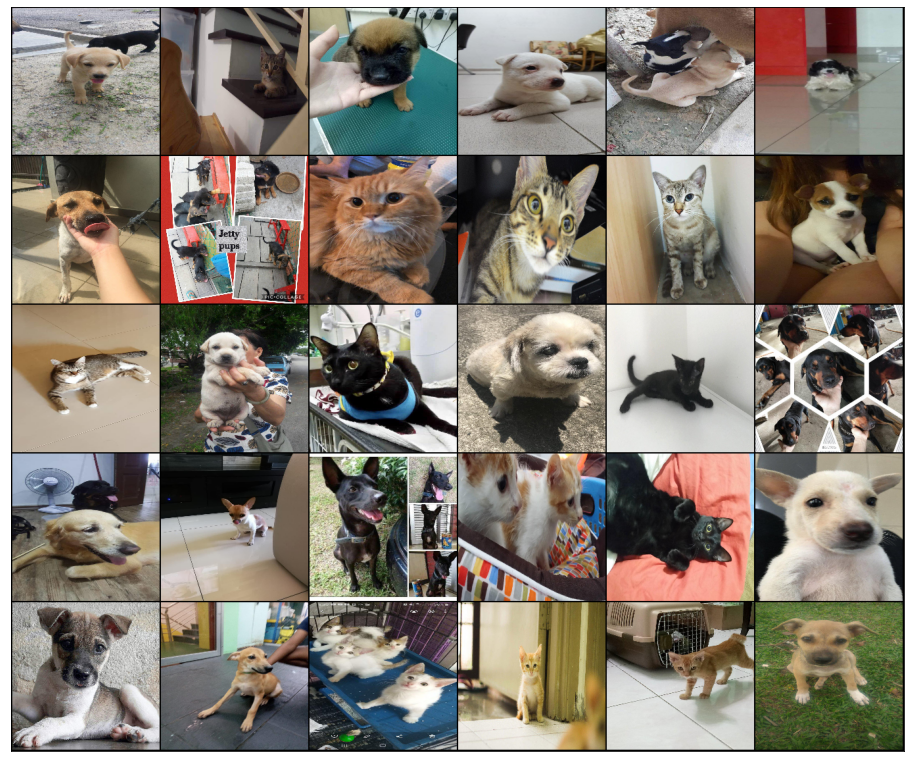

In [15]:
visualize_batch_images(train_loaders)

# Meta data

Exploring meta data, train distribution

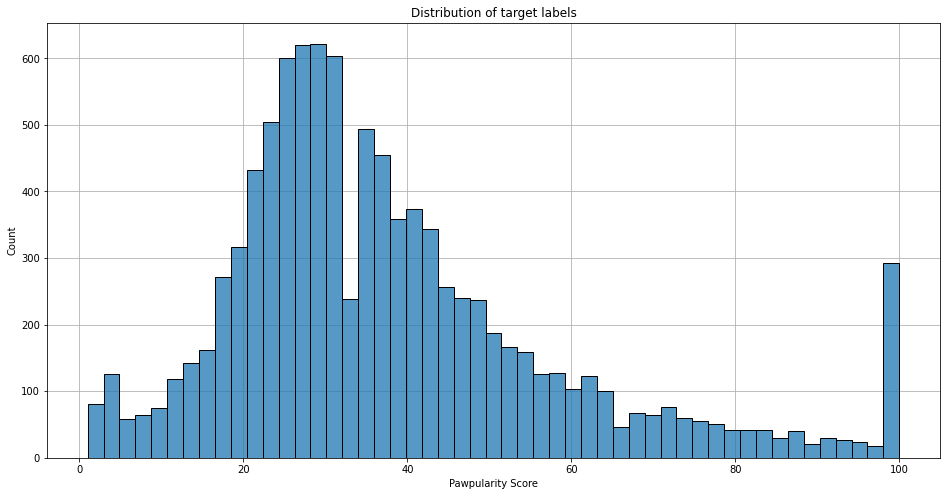

In [16]:
fig,axes = plt.subplots(figsize=(16,8))
sns.histplot(train_df["Pawpularity"].values,ax=axes)
axes.set_xlabel("Pawpularity Score")
axes.set_title("Distribution of target labels")
axes.grid()
axes.set_axisbelow(True)

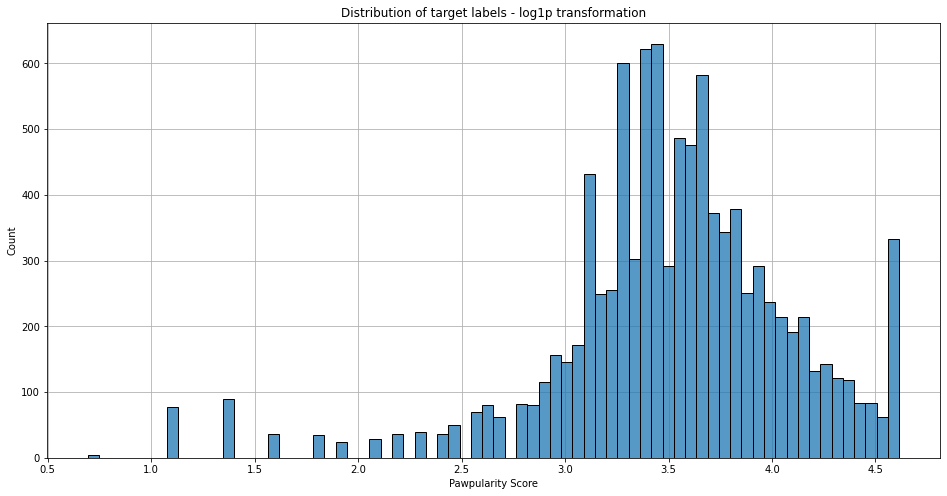

In [17]:
fig,axes = plt.subplots(figsize=(16,8))
sns.histplot(np.log1p(train_df["Pawpularity"].values),ax=axes)
axes.set_xlabel("Pawpularity Score")
axes.set_title("Distribution of target labels - log1p transformation")
axes.grid()
axes.set_axisbelow(True)


In [18]:
# normalization to 0-1 softlabels
# this does not change distribution - just scaling 
from sklearn.preprocessing import MinMaxScaler
og_labels = train_df["Pawpularity"].values.copy()
scaler = MinMaxScaler() # 0 to 1
soft_labels = scaler.fit_transform(og_labels.reshape((-1,1)))


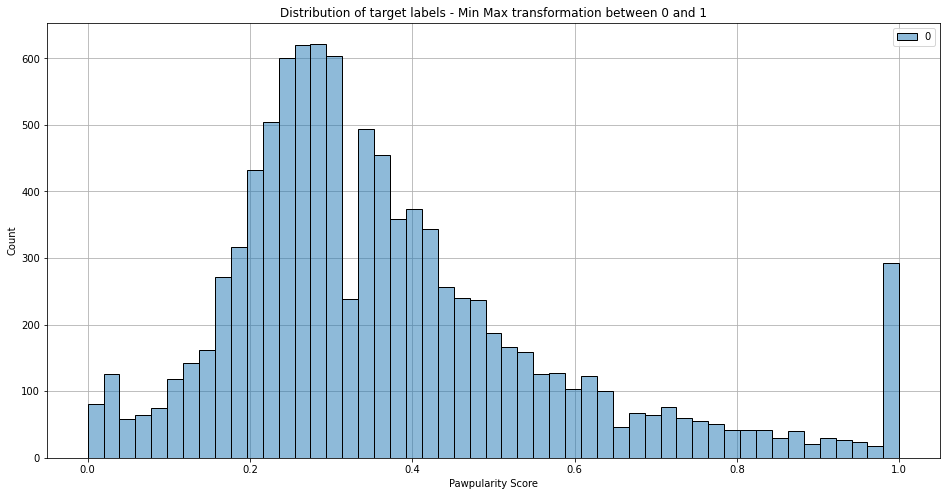

In [19]:
fig,axes = plt.subplots(figsize=(16,8))
sns.histplot(soft_labels,ax=axes)
axes.set_xlabel("Pawpularity Score")
axes.set_title("Distribution of target labels - Min Max transformation between 0 and 1")
axes.grid()
axes.set_axisbelow(True)


# Train basic models 

In [20]:
import torch
from torch import nn
import torch.nn.functional as F

from timm import create_model


In [21]:


class pawNetBasic(nn.Module):
    """
    First cut basic pawNet model
    we will improve on this - this serves as skeleton code
    for other models
    
    timm contains collection of several pretrained models
    """
    
    def __init__(self,dropout=0.2):
        super().__init__()
        self.dropout = 0.2
        
        # initialize layers
        # https://fastai.github.io/timmdocs/tutorial_feature_extractor
        # remove FCL by setting num_classes=0
        self.pretrained = create_model(
            base_config_manager.load_config().model.pretrained, 
            pretrained=True, 
            num_classes=1, 
            in_chans=3
        )
        
    def forward(self,x):
        out = self.pretrained(x)
        
        return out 
        

In [22]:
def train_model(model,train_loader,criterion,optimizer,device = "cpu"):
    """
    Trains model for 1 epoch
    """
    model.train()
    progress_bar = tqdm.notebook.tqdm(train_loader, ascii=True)
    total_loss = 0
    for i, (x_,y_) in enumerate(progress_bar):
        
        # zero the parameter gradients stored 
        optimizer.zero_grad()
        # forward 
        x_ = x_.to(device)
        y_ = y_.to(device)
        # scale y to 0 and 1
        y_s = y_ / 100.
        y_pred = model(x_.to(torch.float)) # logit
        loss = criterion(y_pred.squeeze(),y_s.to(torch.float))
        # backward
        loss.backward()
        # update
        optimizer.step()
        
        total_loss+=loss.item() 
        progress_bar.set_description_str(
            f"Batch: {i+1} | Logloss: {loss.item():.4f}")    
    total_loss /= len(train_loader)
    return total_loss, y_pred


# need to disable auto grad
# @torch.no_grad()
def evaluate(model,valid_loader,criterion,device= "cpu"):
    model.eval()
    y_valid = []
    y_pred_valid = []
    for i, (x,y) in enumerate(valid_loader):
        with torch.no_grad():
            pred = model(x.to(device))
            pred = torch.sigmoid(pred) * 100.
            y_pred_valid.append(pred.squeeze().detach().cpu())
            y_valid.append(y.detach().cpu())
    # convert from list to tensor
    y_valid = torch.cat(y_valid,0)
    y_pred_valid = torch.cat(y_pred_valid,0)

    valid_loss = criterion(y_pred_valid,y_valid)
    
    return valid_loss.item()

# Preparing for training

* create relevant transformations, validation splits

In [23]:
"""
All pre-trained models expect input images normalized in the same way, 
i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), 
where H and W are expected to be at least 224. 
The images have to be loaded in to a range of [0, 1] and then 
normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. 
You can use the following transform to normalize:

https://pytorch.org/vision/stable/models.html

"""
train_transformation = T.Compose(
            [
                T.Resize([224,224]),# imgnet needs at least 224
                T.RandomHorizontalFlip(),
                T.RandomVerticalFlip(),
                T.RandomAffine(15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                T.ConvertImageDtype(torch.float),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] ), # imgnet requirements 
            ]
        )
# train_data = pawnetDataset(annotation_df=train_df,img_dir = os.path.join(file_path,"train"),transform = train_transformation)
# # batchsize should be parameter in config
# train_loader = torch.utils.data.DataLoader(train_data,batch_size=64,num_workers =2, shuffle=True)


test_transformation = T.Compose([
                T.Resize([224,224]),# imgnet needs at least 224
                T.ConvertImageDtype(torch.float),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] ), # imgnet requirements 
                ]
            )

# Training Loop

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)



 Starting: fold 1


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34-43635321.pth" to /root/.cache/torch/hub/checkpoints/resnet34-43635321.pth


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 0 | train logloss :0.669995917908607 | valid RMSE: 20.887983658748038 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 1 | train logloss :0.6656047115402837 | valid RMSE: 20.724631370882918 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 2 | train logloss :0.6651442377798019 | valid RMSE: 20.643156810325866 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 3 | train logloss :0.6645368972132283 | valid RMSE: 20.83001943044356 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 4 | train logloss :0.6645838373130367 | valid RMSE: 20.627609180369085 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 5 | train logloss :0.6646334009785806 | valid RMSE: 20.680993477367995 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 6 | train logloss :0.6639452336295959 | valid RMSE: 20.582165807232393 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 7 | train logloss :0.6639591383357202 | valid RMSE: 20.83709601438022 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 8 | train logloss :0.6639772206544876 | valid RMSE: 20.733444043484354 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 9 | train logloss :0.663806592264483 | valid RMSE: 20.764162676596335 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 10 | train logloss :0.6639195175901536 | valid RMSE: 20.604517528399565 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 11 | train logloss :0.6636026117109484 | valid RMSE: 20.94944199431209 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 12 | train logloss :0.66408575638648 | valid RMSE: 20.575499162146333 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 13 | train logloss :0.6639668383905964 | valid RMSE: 20.632467131954236 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 14 | train logloss :0.6638025776032479 | valid RMSE: 20.673808842840558 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 15 | train logloss :0.6637036891714219 | valid RMSE: 20.73332408320148 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 16 | train logloss :0.663603235636988 | valid RMSE: 20.5304792889495 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 17 | train logloss :0.6632040421808919 | valid RMSE: 20.66579476434883 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 18 | train logloss :0.6638652961100301 | valid RMSE: 20.619570485626483 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 19 | train logloss :0.6635932316703181 | valid RMSE: 20.50080683911459 

 Starting: fold 2


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 0 | train logloss :0.6713415504463257 | valid RMSE: 20.591069835790996 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 1 | train logloss :0.6653800731705081 | valid RMSE: 21.57734642309173 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 2 | train logloss :0.6643439646690122 | valid RMSE: 20.707068462874503 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 3 | train logloss :0.6641004816178353 | valid RMSE: 20.60472858564001 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 4 | train logloss :0.6637613763732295 | valid RMSE: 20.757608144929357 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 5 | train logloss :0.6632726740452551 | valid RMSE: 20.47068365150896 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 6 | train logloss :0.663391940055355 | valid RMSE: 22.358026470515014 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 7 | train logloss :0.6636097815728956 | valid RMSE: 20.45694435309499 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 8 | train logloss :0.6627236311474154 | valid RMSE: 20.55217151909721 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 9 | train logloss :0.6624561072357239 | valid RMSE: 20.514791223299028 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 10 | train logloss :0.6627593141409659 | valid RMSE: 20.312303935351828 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 11 | train logloss :0.6625540573750773 | valid RMSE: 20.568351121835065 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 12 | train logloss :0.6621619861933493 | valid RMSE: 21.565733736231447 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 13 | train logloss :0.6619844278020244 | valid RMSE: 20.297892133145947 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 14 | train logloss :0.6613566471684363 | valid RMSE: 22.879304741386235 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 15 | train logloss :0.6618762612342834 | valid RMSE: 20.386363599248917 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 16 | train logloss :0.6607459264416848 | valid RMSE: 20.277027319458405 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 17 | train logloss :0.6607120176476817 | valid RMSE: 20.623038643720538 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 18 | train logloss :0.6607054068196204 | valid RMSE: 20.901176806451144 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 19 | train logloss :0.6602718801267685 | valid RMSE: 20.692374862286982 

 Starting: fold 3


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 0 | train logloss :0.6699381523555324 | valid RMSE: 20.653701324894982 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 1 | train logloss :0.6641814756777978 | valid RMSE: 23.111606657796155 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 2 | train logloss :0.6626636376304011 | valid RMSE: 20.469002711941886 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 3 | train logloss :0.6616358627234736 | valid RMSE: 20.61436086274073 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 4 | train logloss :0.6610037295087692 | valid RMSE: 20.71210005931768 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 5 | train logloss :0.6601145060793046 | valid RMSE: 21.13813689280179 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 6 | train logloss :0.6586741742587858 | valid RMSE: 20.27607536427438 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 7 | train logloss :0.6585033016820108 | valid RMSE: 21.009353008085693 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 8 | train logloss :0.6572156510045452 | valid RMSE: 20.390059259393105 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 9 | train logloss :0.6565385359910226 | valid RMSE: 20.339574804372294 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 10 | train logloss :0.6571656979860798 | valid RMSE: 20.699415941337573 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 11 | train logloss :0.6559203180574602 | valid RMSE: 20.609665227296876 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 12 | train logloss :0.6556692618516183 | valid RMSE: 20.01527813053264 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 13 | train logloss :0.6552306875105827 | valid RMSE: 21.18213182709036 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 14 | train logloss :0.6554252856200741 | valid RMSE: 20.38168356398322 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 15 | train logloss :0.6540532237099063 | valid RMSE: 20.37813389553747 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 16 | train logloss :0.6542454390756546 | valid RMSE: 20.317386731892498 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 17 | train logloss :0.6535081007788258 | valid RMSE: 20.77349626260963 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 18 | train logloss :0.6534622316398928 | valid RMSE: 20.248839545260058 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 19 | train logloss :0.6524820197974482 | valid RMSE: 21.424716886165466 

 Starting: fold 4


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 0 | train logloss :0.6705368488065658 | valid RMSE: 20.671776088671148 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 1 | train logloss :0.6659122849664381 | valid RMSE: 20.816006385139584 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 2 | train logloss :0.6642189352743088 | valid RMSE: 21.669059190945582 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 3 | train logloss :0.6630870276881803 | valid RMSE: 20.512853547094107 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 4 | train logloss :0.6634164452552795 | valid RMSE: 20.474614498622127 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 5 | train logloss :0.6621695545411879 | valid RMSE: 20.3868523509466 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 6 | train logloss :0.6627716205773815 | valid RMSE: 20.8296663439432 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 7 | train logloss :0.6617708114847061 | valid RMSE: 20.39427275202488 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 8 | train logloss :0.6609743242302248 | valid RMSE: 20.973667165173303 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 9 | train logloss :0.660933629639687 | valid RMSE: 20.438642277424673 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 10 | train logloss :0.6603798342327918 | valid RMSE: 19.867301937588227 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 11 | train logloss :0.6591829345110924 | valid RMSE: 19.756257816205746 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 12 | train logloss :0.6595013170473037 | valid RMSE: 20.88750736366567 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 13 | train logloss :0.6587778411565288 | valid RMSE: 19.804734498218398 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 14 | train logloss :0.6580443141921875 | valid RMSE: 19.6909161222726 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 15 | train logloss :0.6570932067209675 | valid RMSE: 19.812951308444212 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 16 | train logloss :0.6569904978236845 | valid RMSE: 20.284079426334046 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 17 | train logloss :0.6563536976614306 | valid RMSE: 20.047368983829976 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 18 | train logloss :0.6564471236159725 | valid RMSE: 19.78744241172329 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 19 | train logloss :0.654932574399056 | valid RMSE: 20.132710182365148 

 Starting: fold 5


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 0 | train logloss :0.6729669691093506 | valid RMSE: 20.632310346265378 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 1 | train logloss :0.6659284998332301 | valid RMSE: 20.970915499209852 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 2 | train logloss :0.6656569535693815 | valid RMSE: 20.686108130339022 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 3 | train logloss :0.6648558743538395 | valid RMSE: 20.61561398646818 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 4 | train logloss :0.664691208351043 | valid RMSE: 20.598205547506893 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 5 | train logloss :0.664156251376675 | valid RMSE: 20.50196196308874 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 6 | train logloss :0.6642887097212576 | valid RMSE: 20.443755612770552 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 7 | train logloss :0.6638283277711561 | valid RMSE: 20.563627913594186 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 8 | train logloss :0.6637843082989415 | valid RMSE: 20.41555289000735 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 9 | train logloss :0.6636960559314297 | valid RMSE: 20.46352807912928 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 10 | train logloss :0.6633798335829089 | valid RMSE: 20.477557295322192 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 11 | train logloss :0.6633534417037041 | valid RMSE: 20.927194729539046 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 12 | train logloss :0.6632534106892924 | valid RMSE: 20.322791863831725 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 13 | train logloss :0.6630118277765089 | valid RMSE: 20.38967460668282 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 14 | train logloss :0.6627713985020115 | valid RMSE: 20.406719582077923 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 15 | train logloss :0.6625602139580634 | valid RMSE: 20.346261005749003 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 16 | train logloss :0.6623082204211143 | valid RMSE: 20.38877356297685 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 17 | train logloss :0.6623410693099422 | valid RMSE: 20.39509499615885 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 18 | train logloss :0.662002240938525 | valid RMSE: 20.476883671412946 


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 19 | train logloss :0.6617616737081159 | valid RMSE: 20.261811755738922 


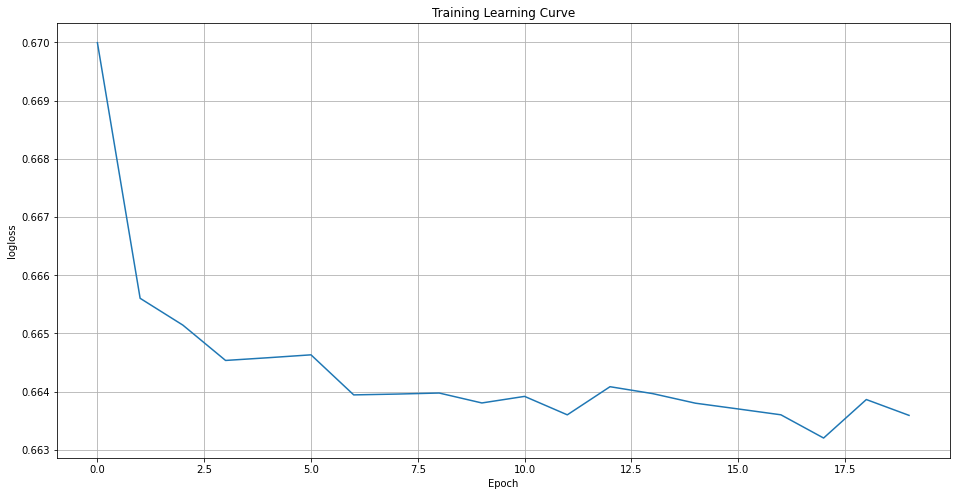

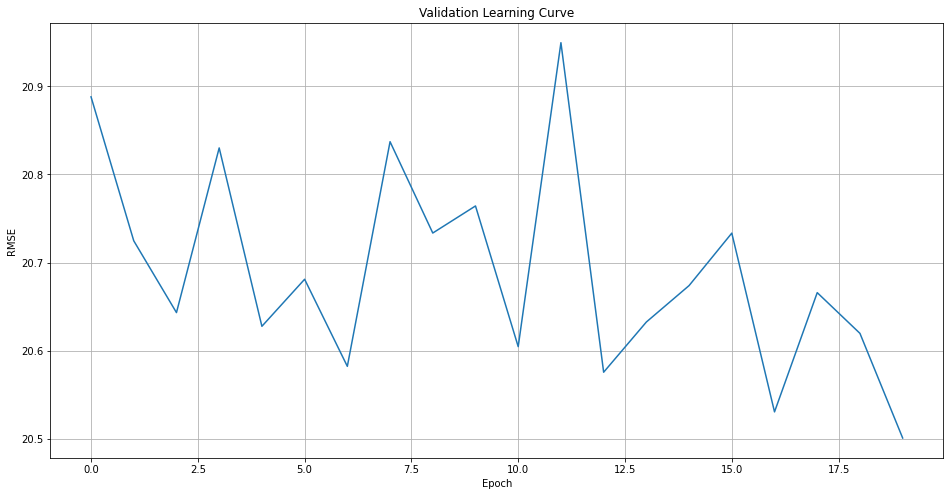

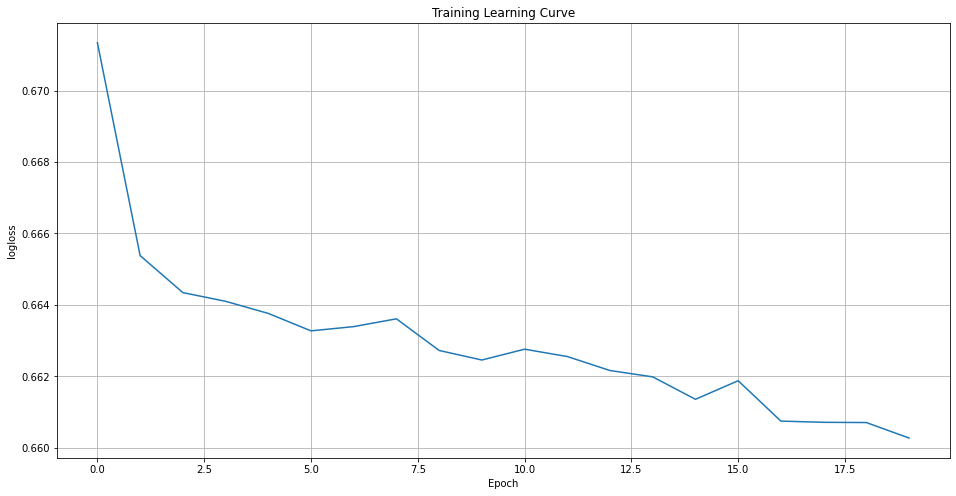

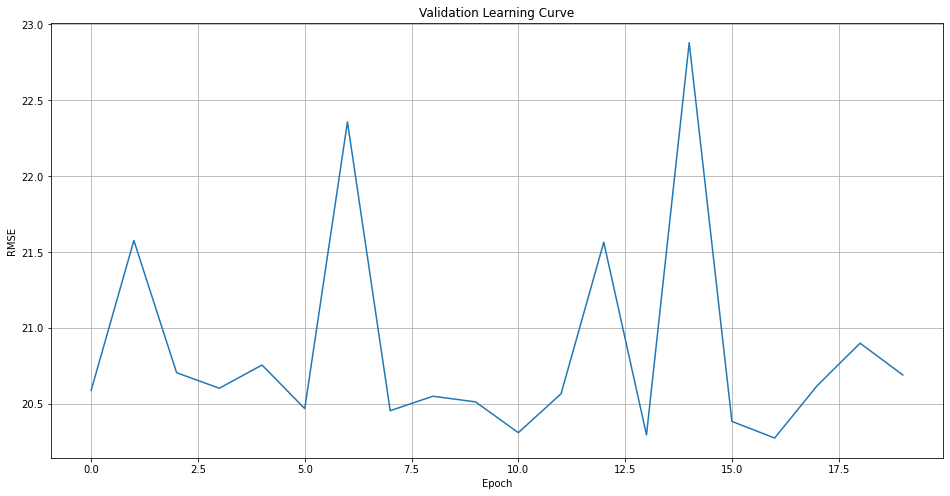

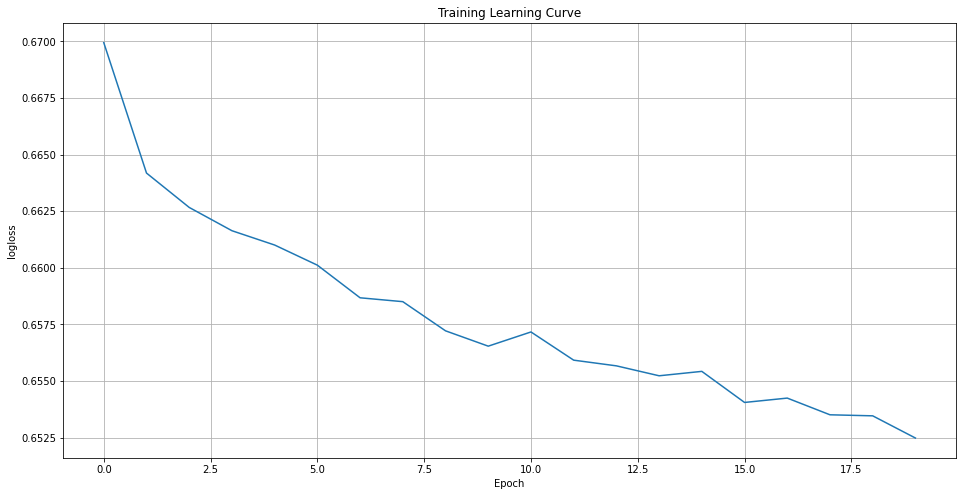

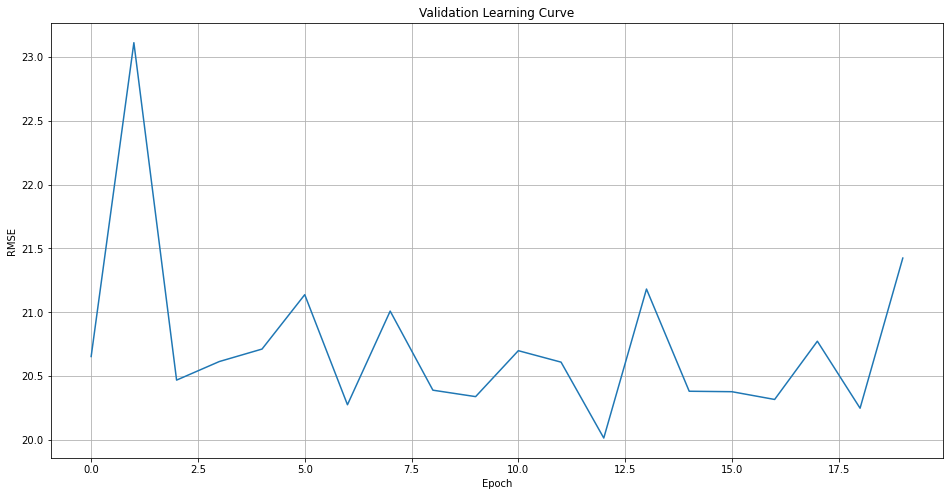

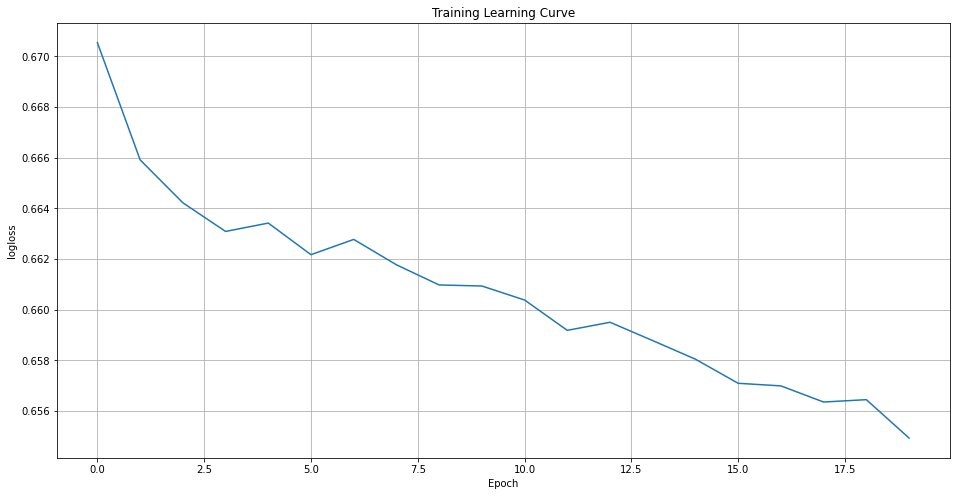

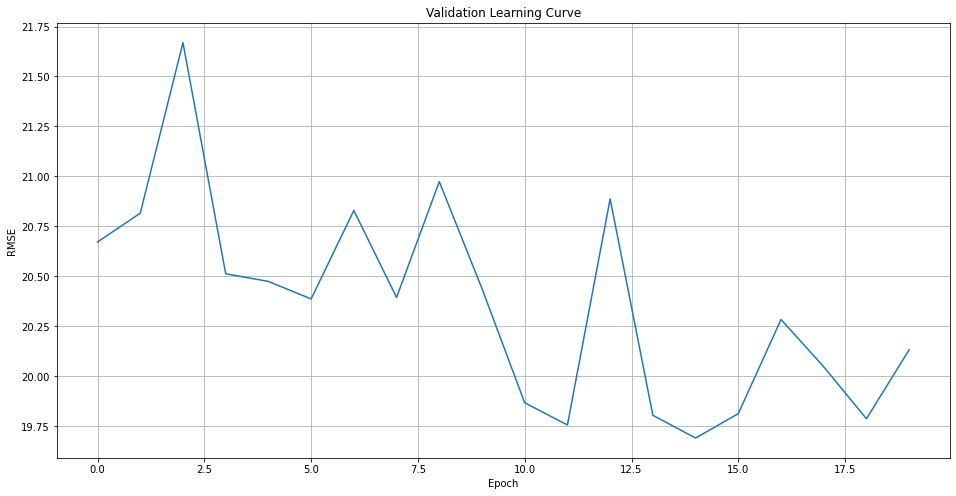

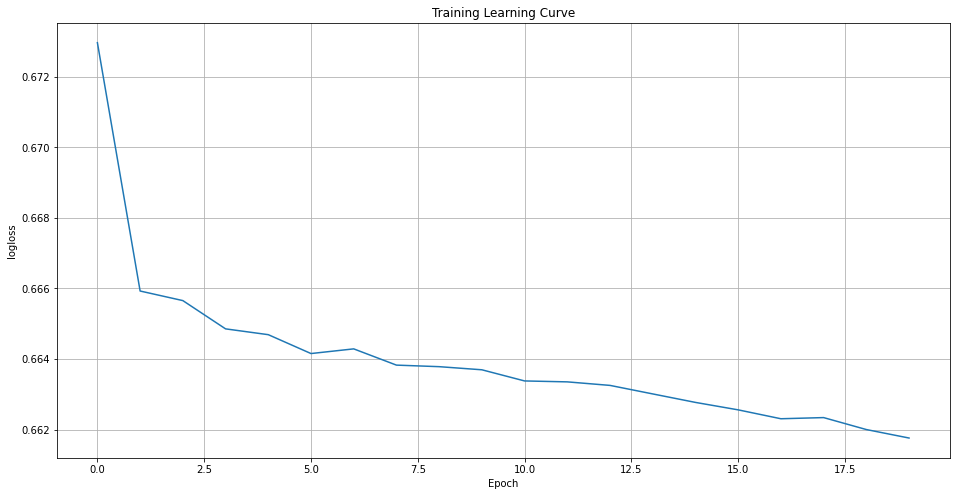

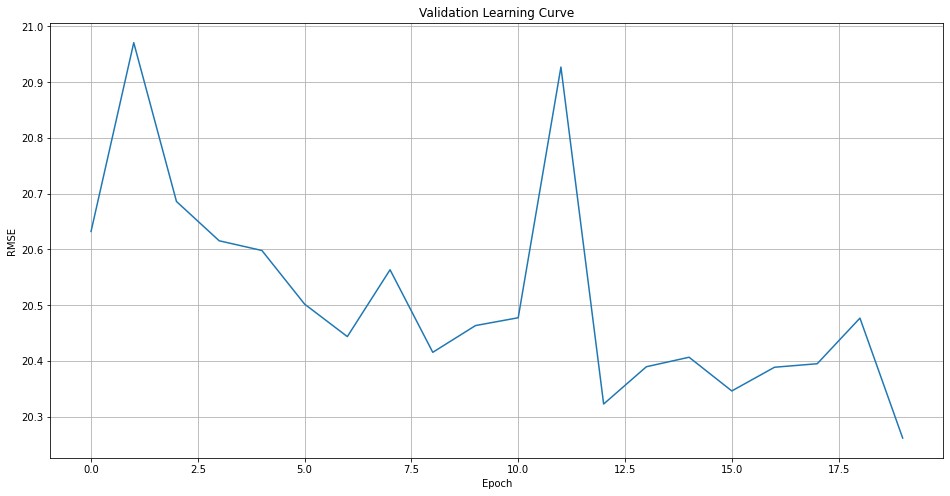

In [24]:
seed_everything()



early_stopping_patience = 10
early_stopping_counter = 0


# perfrom stratified sampling k fold model training
# TODO: Add k fold to config
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)
splits = skf.split(train_df["Id"],train_df["Pawpularity"])

# create mse criteron for validation
mse_criterion = torch.nn.MSELoss()

skf_train_list = [] # to store across folds
skf_valid_list = [] # to store across folds

for i, (train_index, test_index) in enumerate(splits):
    print("\n Starting: fold {}".format(i+1))
    
    # initialize model 
    model = pawNetBasic().to(device)

    criterion = torch.nn.BCEWithLogitsLoss()
    optimzer = torch.optim.Adam(model.parameters()) # lr=0.0001

    X_train, X_valid = train_df.iloc[train_index], train_df.iloc[test_index]
    X_train.reset_index(inplace=True,drop=True)
    X_valid.reset_index(inplace=True,drop=True)
    
    # build loaders
    train_data = pawnetDataset(annotation_df=X_train,img_dir = os.path.join(file_path,"train"),transform = train_transformation) # can set custom len to let model exceed training size (since we are augmenting)
    val_data = pawnetDataset(annotation_df=X_valid,img_dir = os.path.join(file_path,"train"),transform = test_transformation)
    train_loader = torch.utils.data.DataLoader(train_data,batch_size=64,num_workers =2, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data,batch_size=64,num_workers =2, shuffle=False)
    
    # # to plot learning curve
    train_loss_list = []
    valid_loss_list = []
    best_valid = np.inf
    best_model = None
    
    
    ##################
    # Training loop
    ##################
    # TODO: make epoch in config
    for epoch in range(20):
        loss, _ = train_model(model,train_loader,criterion,optimzer,device=device)
        valid_loss = evaluate(model,val_loader,mse_criterion,device=device)
        valid_loss = np.sqrt(valid_loss) # RMSE
        print(f"Epoch: {epoch} | train logloss :{loss} | valid RMSE: {valid_loss} ")
        
        train_loss_list.append(loss)
        valid_loss_list.append(valid_loss)
        # check early stopping
        if epoch >0:
            # check better than best, if not ...
            if best_valid < valid_loss:
                early_stopping_counter+=1
            else:
                early_stopping_counter = 0
                best_valid = valid_loss
                best_model = copy.deepcopy(model)

            if early_stopping_counter == early_stopping_patience:
                break
                print("Early stopping activated")
    if best_model is not None:
        torch.save(best_model.state_dict(),f"pawnet_fold{i}.pt")
    else:
        torch.save(model.state_dict(),f"pawnet_fold{i}.pt")
        
    
    # store learning curve for this epoch
    skf_train_list.append(train_loss_list)
    skf_valid_list.append(valid_loss_list)
    
    
    # visualize model 
    
    fig,axes = plt.subplots(figsize=(16,8))
    axes.plot(np.arange(len(train_loss_list)),train_loss_list)
    axes.set_xlabel("Epoch")
    axes.set_ylabel("logloss")
    axes.set_title("Training Learning Curve")
    axes.grid()
    axes.set_axisbelow(True)
    plt.savefig(f"training_curve_{i}.png")

    fig,axes = plt.subplots(figsize=(16,8))
    axes.plot(np.arange(len(valid_loss_list)),valid_loss_list)
    axes.set_xlabel("Epoch")
    axes.set_ylabel("RMSE")
    axes.set_title("Validation Learning Curve")
    axes.grid()
    axes.set_axisbelow(True)
    plt.savefig("fvalidation_curve_{i}.png")